# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning II</font>

# Redes Neurais Recorrentes LSTM - Long Short-Term Memory 

## Prevendo Séries Temporais com LSTMs

In [33]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [34]:
import keras as k
k.__version__

'2.5.0'

In [10]:
# Imports
import math
import numpy
import pandas
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Imports para formatação dos gráficos
#plt.style.use('fivethirtyeight')
import matplotlib as m

m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

In [11]:
# Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [12]:
# Random seed 
numpy.random.seed(7)

In [6]:
# Carrega o dataset
#dataframe = pandas.read_csv('passageiros.csv', usecols = [1], engine = 'python', skipfooter = 3)
#dataset = dataframe.values
#dataset = dataset.astype('float32')

In [13]:
# Carrega os dataframe
dataframe = pandas.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pandas.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()


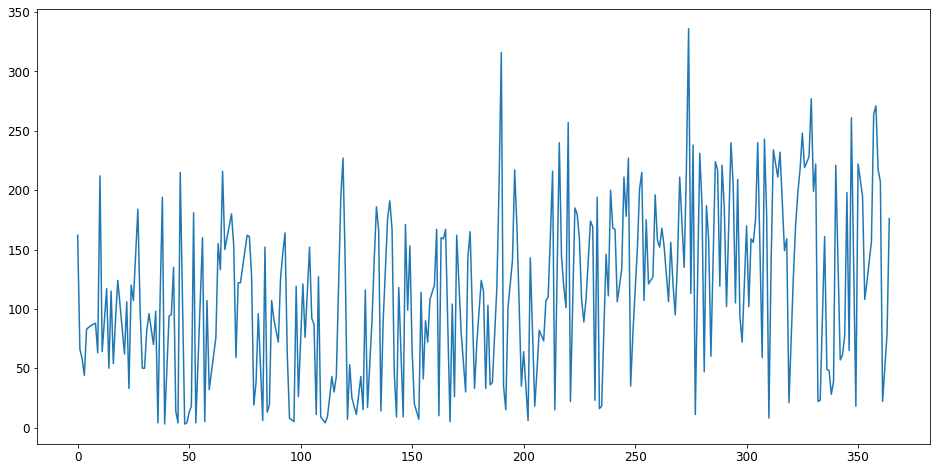

In [19]:
dataset=dataframe.copy()
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [9]:
# Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. Podemos normalizar facilmente o conjunto de dados usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape do input para: [samples, time steps, features]
# A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de matriz específica 
# na forma de: [amostras, etapas de tempo, características]. Nossos dados preparados estão na forma: [amostras,
# features] e estamos enquadrando o problema como um único passo para cada amostra. Podemos transformar
# os dados de treino e de teste na estrutura esperada usando numpy.reshape() 
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Cria o modelo LSTM
# Agora estamos prontos para projetar nossa rede LSTM para esse problema. A rede tem uma
# camada visível com 1 entrada, uma camada oculta com 4 blocos LSTM ou neurônios e uma camada de saída
# que faz uma previsão de valor único. A função de ativação sigmoid padrão é usada para
# os blocos de memória LSTM. A rede é treinada em 200 épocas e um tamanho de lote (batch_size) de 1 é usado.
model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 200, batch_size = 1, verbose = 2)

# Previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em teste para o plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot do baseline e previsões
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: name 'MinMaxScaler' is not defined

In [13]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 58.38 RMSE
Score em Teste: 84.31 RMSE


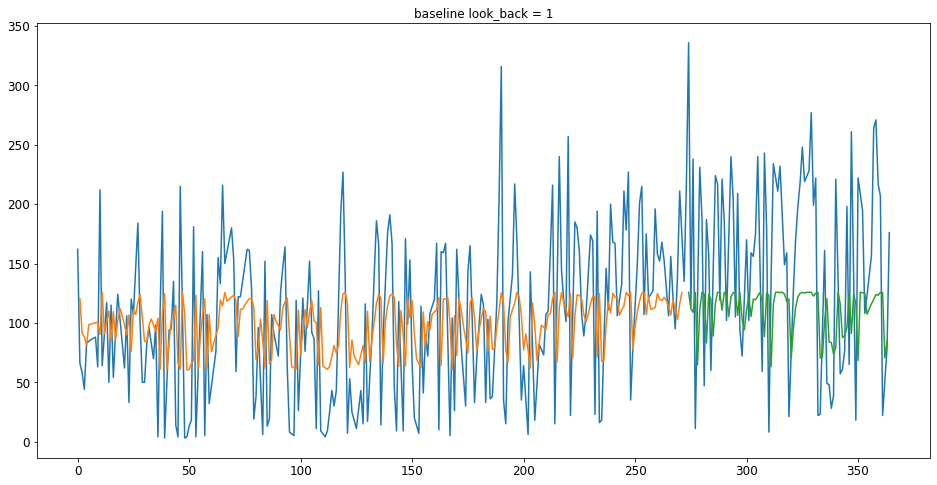

In [18]:
# Plot do baseline e previsões
plt.title('baseline look_back = 1')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Prevendo Séries Temporais com LSTMs e Método Window

Podemos também explicar o problema de modo que várias etapas de tempo anteriores possam ser usadas para previsão do próximo passo. Isso é chamado de janela (window) e o tamanho da janela é um parâmetro que pode ser configurado para cada problema.

In [9]:
# Carrega o dataset
#dataframe = pandas.read_csv('passageiros.csv', usecols = [1], engine = 'python', skipfooter = 3)
#dataset = dataframe.values
#dataset = dataset.astype('float32')

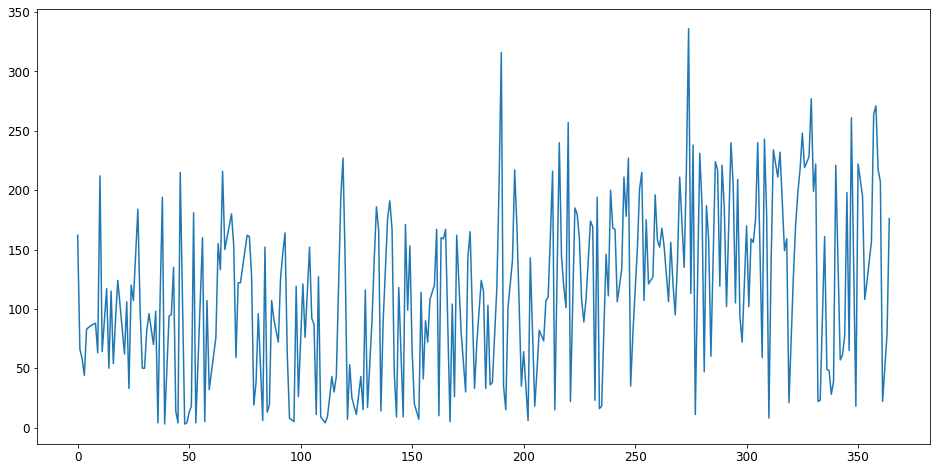

In [41]:
dataset=dataframe.copy()
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

Epoch 1/200
242/242 - 4s - loss: 0.0440
Epoch 2/200
242/242 - 1s - loss: 0.0382
Epoch 3/200
242/242 - 1s - loss: 0.0370
Epoch 4/200
242/242 - 1s - loss: 0.0364
Epoch 5/200
242/242 - 1s - loss: 0.0353
Epoch 6/200
242/242 - 1s - loss: 0.0344
Epoch 7/200
242/242 - 1s - loss: 0.0335
Epoch 8/200
242/242 - 1s - loss: 0.0331
Epoch 9/200
242/242 - 1s - loss: 0.0328
Epoch 10/200
242/242 - 1s - loss: 0.0323
Epoch 11/200
242/242 - 1s - loss: 0.0320
Epoch 12/200
242/242 - 1s - loss: 0.0313
Epoch 13/200
242/242 - 1s - loss: 0.0309
Epoch 14/200
242/242 - 1s - loss: 0.0312
Epoch 15/200
242/242 - 1s - loss: 0.0310
Epoch 16/200
242/242 - 1s - loss: 0.0304
Epoch 17/200
242/242 - 1s - loss: 0.0302
Epoch 18/200
242/242 - 1s - loss: 0.0306
Epoch 19/200
242/242 - 1s - loss: 0.0298
Epoch 20/200
242/242 - 1s - loss: 0.0299
Epoch 21/200
242/242 - 1s - loss: 0.0290
Epoch 22/200
242/242 - 1s - loss: 0.0293
Epoch 23/200
242/242 - 1s - loss: 0.0295
Epoch 24/200
242/242 - 1s - loss: 0.0291
Epoch 25/200
242/242 - 1s

Epoch 199/200
242/242 - 1s - loss: 0.0104
Epoch 200/200
242/242 - 1s - loss: 0.0109
Score em Treino: 33.14 RMSE
Score em Teste: 102.61 RMSE


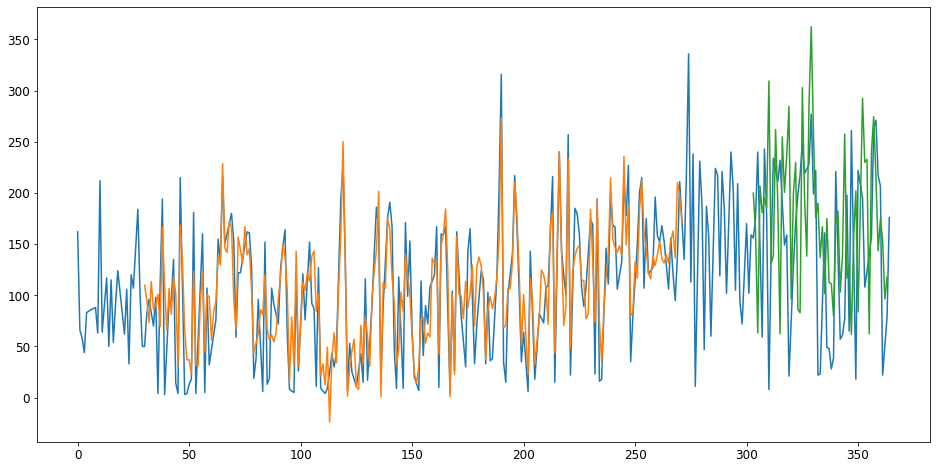

In [42]:
# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape do input para: [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Cria o modelo LSTM
model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 200, batch_size = 1, verbose = 2)

# Previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em teste para o plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot do baseline e previsões
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [39]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 56.38 RMSE
Score em Teste: 81.68 RMSE


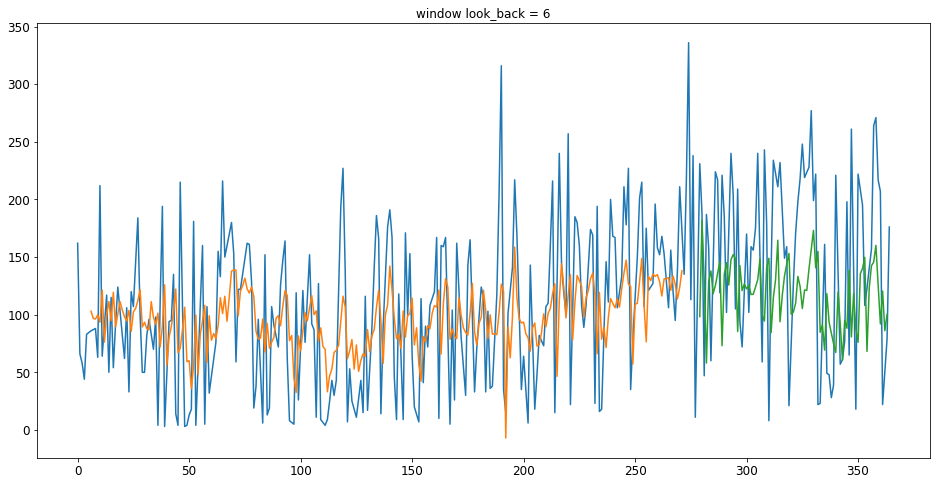

In [40]:
# Plot do baseline e previsões
plt.title('window look_back = 6')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 49.93 RMSE
Score em Teste: 88.30 RMSE


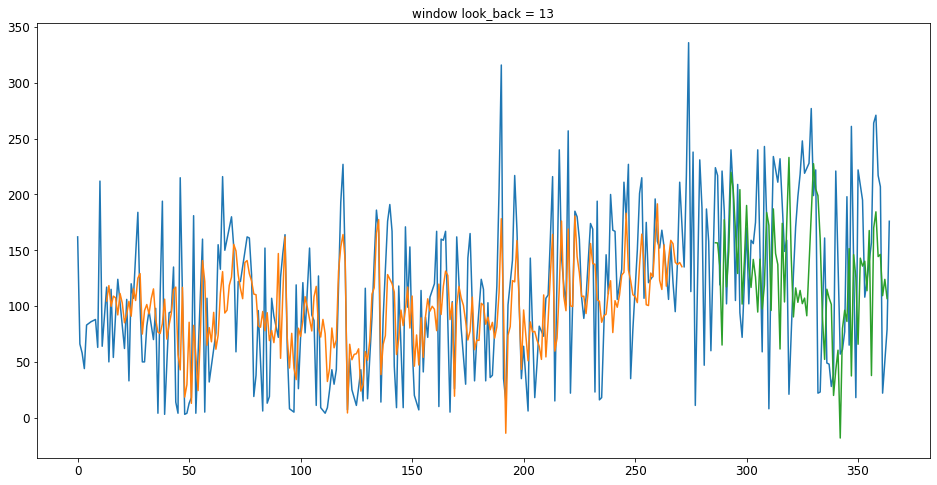

In [23]:
# Plot do baseline e previsões
plt.title('window look_back = 13')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [35]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 45.25 RMSE
Score em Teste: 94.05 RMSE


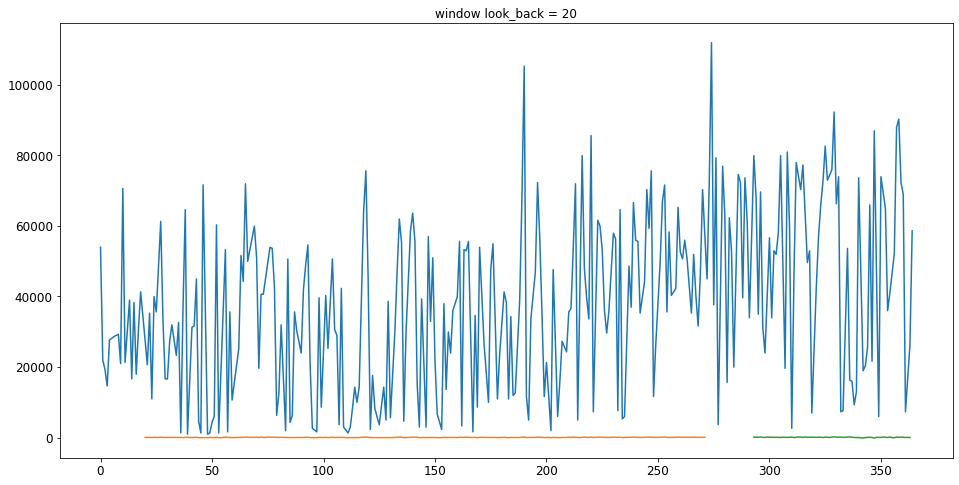

In [36]:
# Plot do baseline e previsões
plt.title('window look_back = 20')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [43]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 33.14 RMSE
Score em Teste: 102.61 RMSE


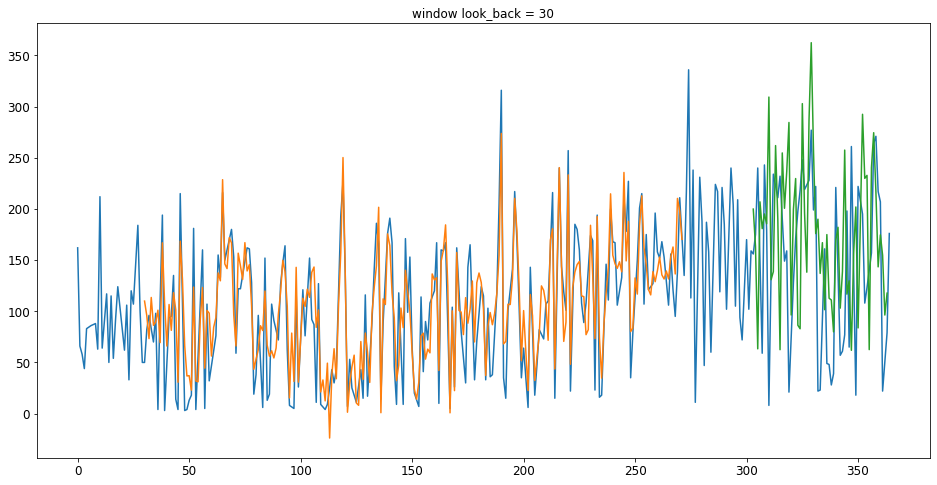

In [44]:
# Plot do baseline e previsões
plt.title('window look_back = 30')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Prevendo Séries Temporais com LSTMs e Time Steps

Você pode ter notado que a preparação de dados para a rede LSTM inclui etapas de tempo (time steps). Alguns problemas de sequência podem ter uma série variada de etapas de tempo por amostra. Por exemplo, você pode ter medidas de uma máquina industrial levando a um ponto de falha ou a um ponto de aumento de performance. Cada incidente seria uma amostra, as observações que levaram ao evento seriam os passos de tempo e as variáveis observadas seriam os recursos. Passos de tempo fornecem outras forma de tratar nosso problema de séries temporais. Como o exemplo acima usando o método Window, podemos ter passos de tempo anteriores em nossas séries temporais como entradas para prever a saída no próximo passo.

Em vez de reescrever as observações passadas como características de entrada separadas, podemos usá-las como passos de tempo de uma característica (atributo) de entrada, que é realmente um enquadramento mais preciso do problema. Podemos fazer isso usando a mesma representação de dados que no exemplo anterior do método window, exceto quando fazemos o reshape dos dados, onde definimos as colunas como a dimensão time step e alteramos a dimensão das features de volta para 1.

O método window cria novos recursos, como novos atributos para o modelo, enquanto os timesteps são uma sequência dentro de um lote para um determinado recurso.

In [11]:
# Carrega o dataset
#dataframe = pandas.read_csv('passageiros.csv', usecols = [1], engine = 'python', skipfooter = 3)
#dataset = dataframe.values
#dataset = dataset.astype('float32')

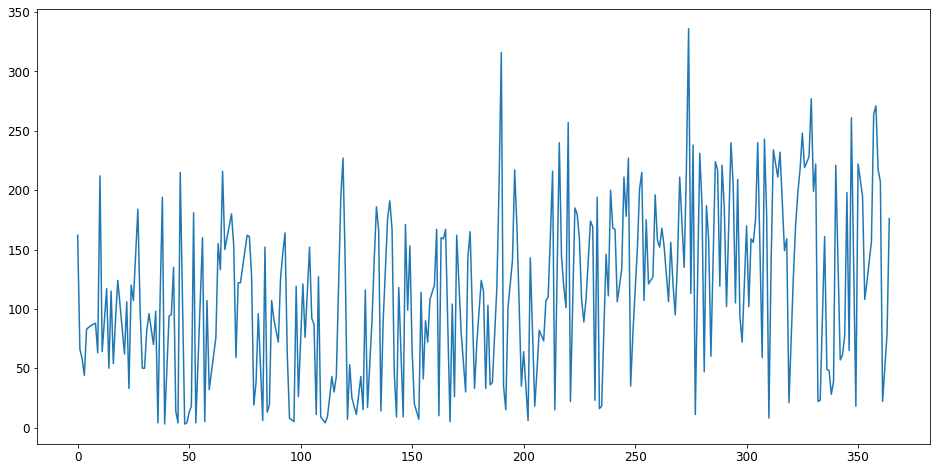

In [128]:
dataset=dataframe.copy()
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

Epoch 1/200
242/242 - 4s - loss: 0.0481
Epoch 2/200
242/242 - 1s - loss: 0.0352
Epoch 3/200
242/242 - 1s - loss: 0.0355
Epoch 4/200
242/242 - 1s - loss: 0.0348
Epoch 5/200
242/242 - 1s - loss: 0.0349
Epoch 6/200
242/242 - 1s - loss: 0.0343
Epoch 7/200
242/242 - 1s - loss: 0.0344
Epoch 8/200
242/242 - 1s - loss: 0.0341
Epoch 9/200
242/242 - 1s - loss: 0.0344
Epoch 10/200
242/242 - 1s - loss: 0.0339
Epoch 11/200
242/242 - 1s - loss: 0.0338
Epoch 12/200
242/242 - 1s - loss: 0.0342
Epoch 13/200
242/242 - 1s - loss: 0.0338
Epoch 14/200
242/242 - 1s - loss: 0.0334
Epoch 15/200
242/242 - 1s - loss: 0.0336
Epoch 16/200
242/242 - 1s - loss: 0.0335
Epoch 17/200
242/242 - 1s - loss: 0.0340
Epoch 18/200
242/242 - 1s - loss: 0.0333
Epoch 19/200
242/242 - 1s - loss: 0.0336
Epoch 20/200
242/242 - 1s - loss: 0.0337
Epoch 21/200
242/242 - 1s - loss: 0.0334
Epoch 22/200
242/242 - 1s - loss: 0.0333
Epoch 23/200
242/242 - 1s - loss: 0.0329
Epoch 24/200
242/242 - 1s - loss: 0.0333
Epoch 25/200
242/242 - 1s

Epoch 199/200
242/242 - 1s - loss: 0.0318
Epoch 200/200
242/242 - 1s - loss: 0.0312
Score em Treino: 58.55 RMSE
Score em Teste: 75.89 RMSE


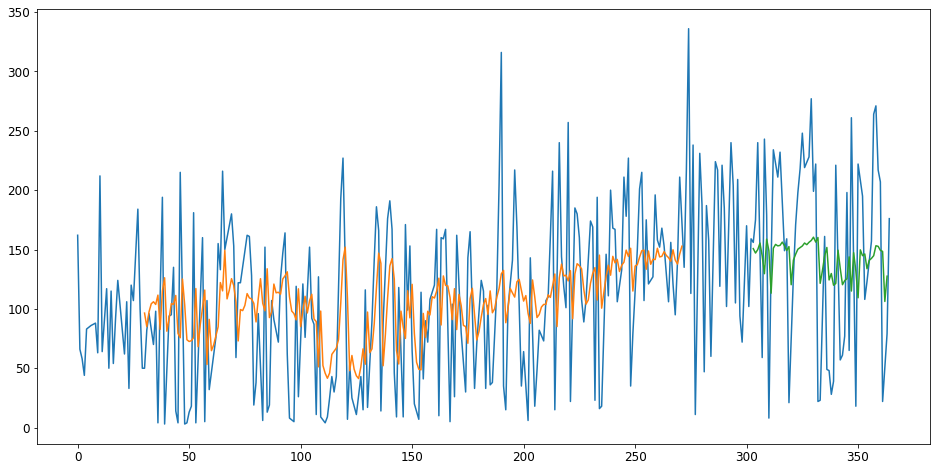

In [129]:
# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Cria o modelo LSTM
model = Sequential()
model.add(LSTM(4, input_shape = (None, 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 200, batch_size = 1, verbose = 2)

# Previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em teste para o plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot do baseline e previsões
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [94]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 58.63 RMSE
Score em Teste: 81.57 RMSE


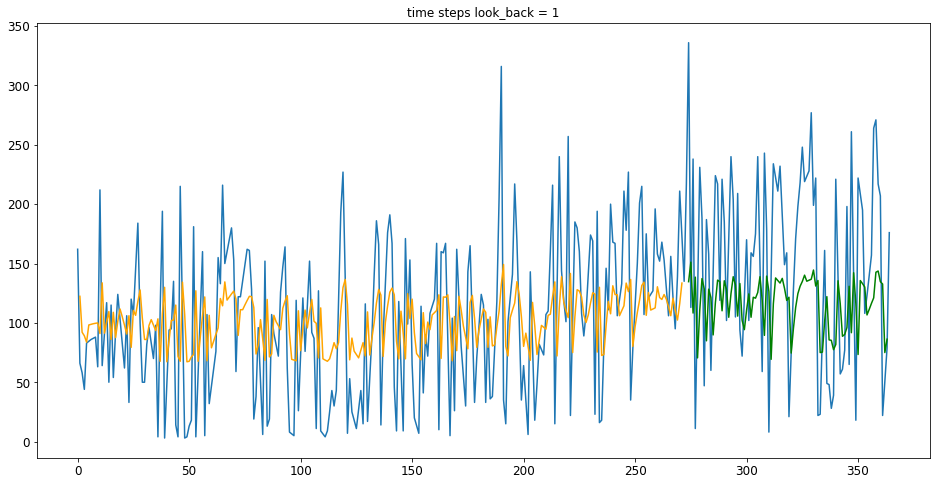

In [95]:
# Plot do baseline e previsões
plt.title('time steps look_back = 1')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

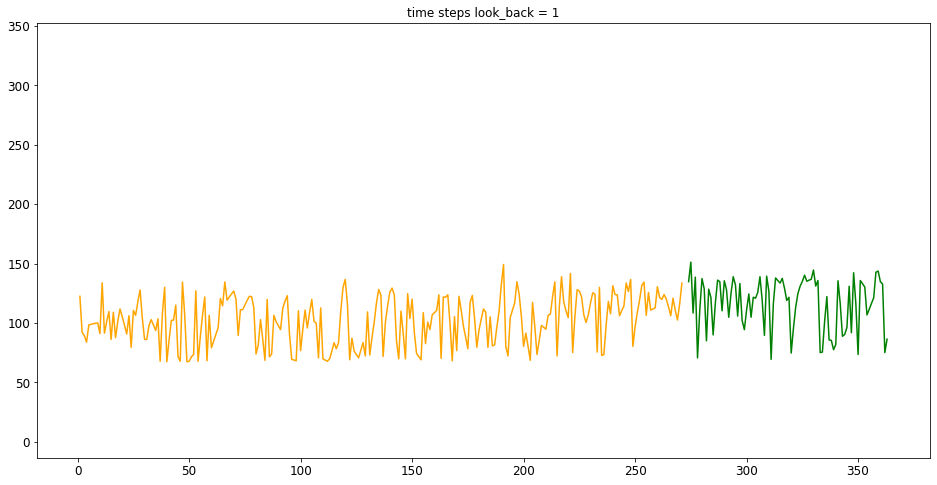

In [96]:
# Plot do baseline e previsões
plt.title('time steps look_back = 1')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [114]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 57.81 RMSE
Score em Teste: 77.73 RMSE


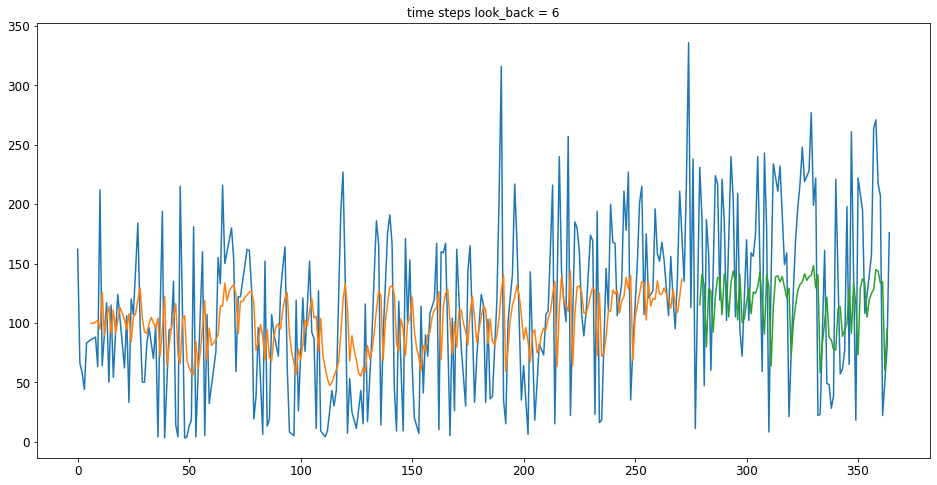

In [115]:
# Plot do baseline e previsões
plt.title('time steps look_back = 6')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

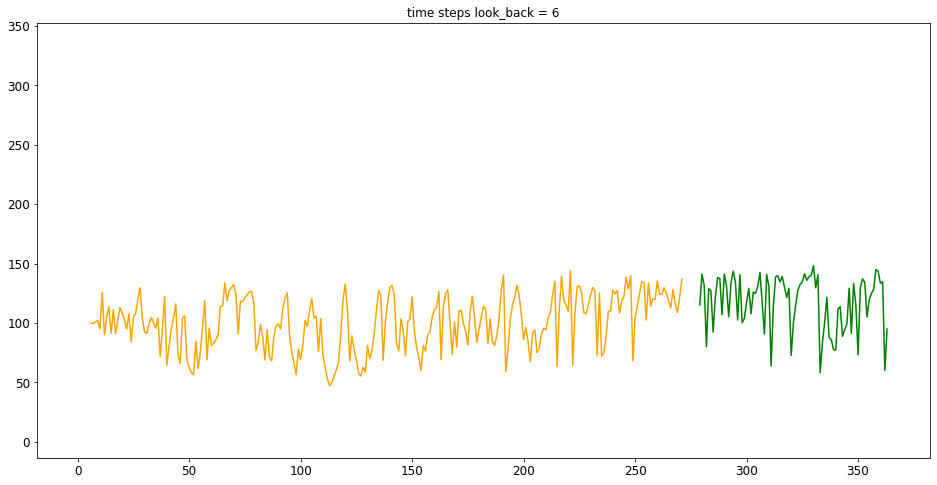

In [116]:
# Plot do baseline e previsões
plt.title('time steps look_back = 6')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [120]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 58.37 RMSE
Score em Teste: 75.42 RMSE


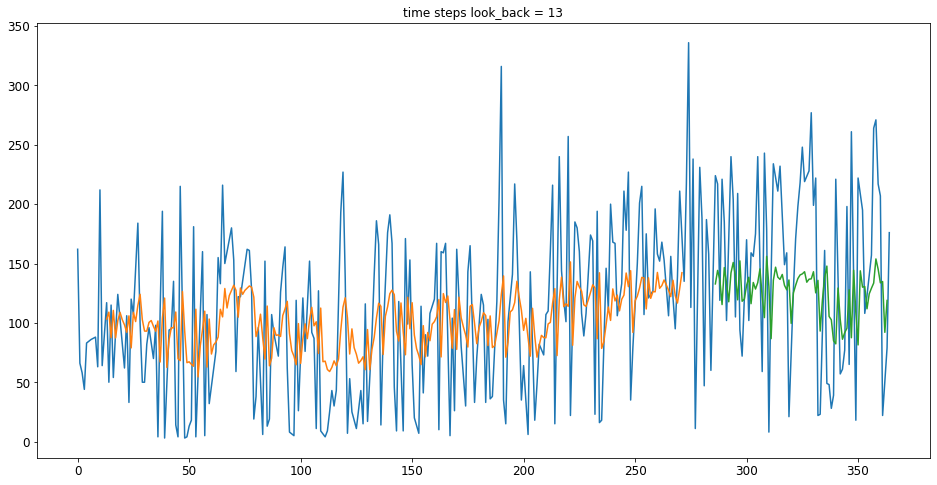

In [121]:
# Plot do baseline e previsões
plt.title('time steps look_back = 13')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

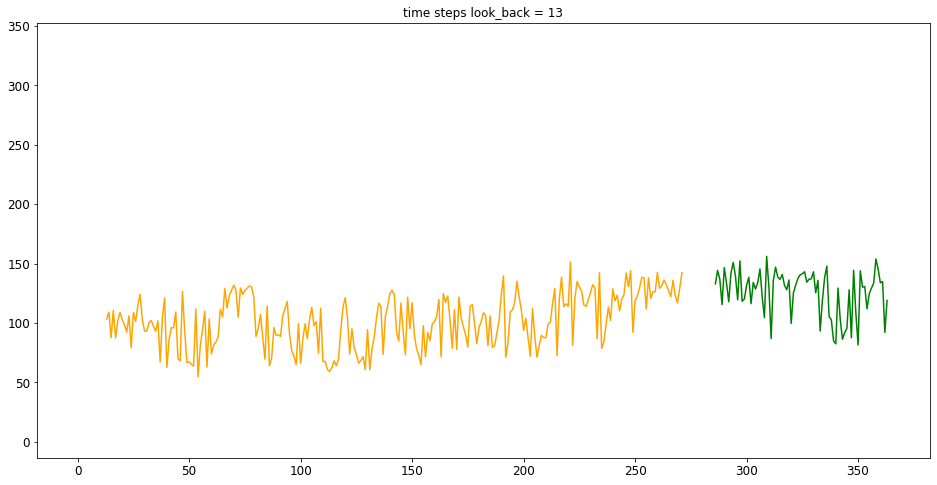

In [122]:
# Plot do baseline e previsões
plt.title('time steps look_back = 13')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [125]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 57.17 RMSE
Score em Teste: 85.61 RMSE


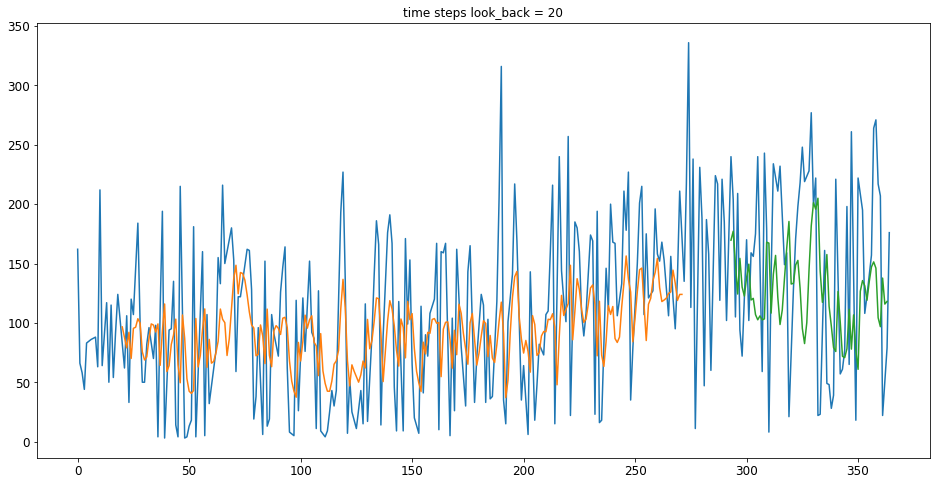

In [126]:
# Plot do baseline e previsões
plt.title('time steps look_back = 20')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

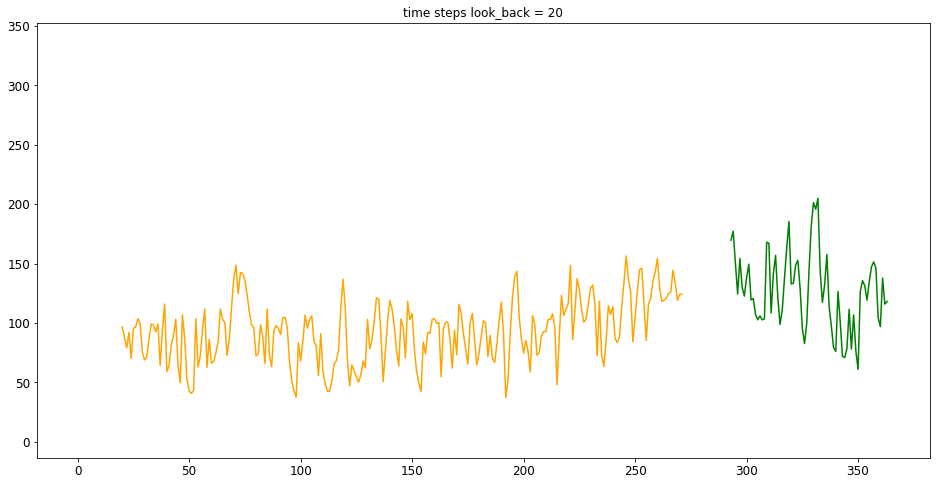

In [127]:
# Plot do baseline e previsões
plt.title('time steps look_back = 20')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [130]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 58.55 RMSE
Score em Teste: 75.89 RMSE


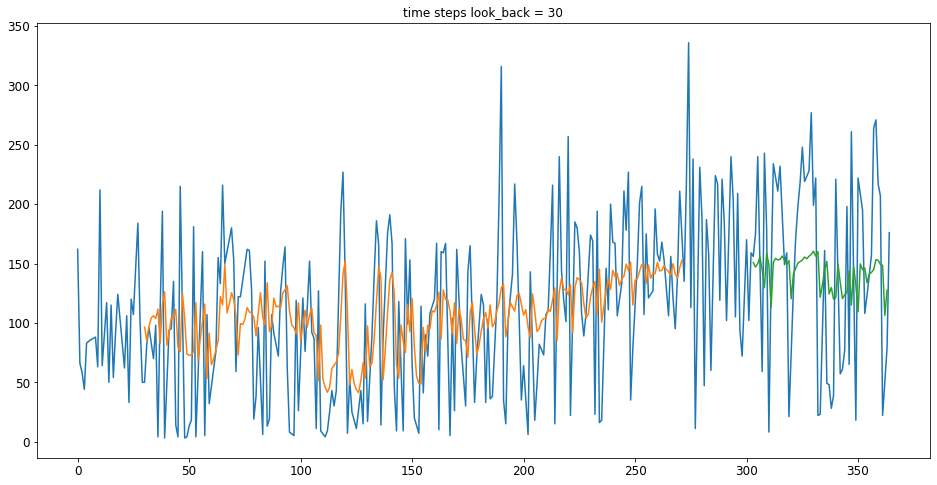

In [131]:
# Plot do baseline e previsões
plt.title('time steps look_back = 30')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

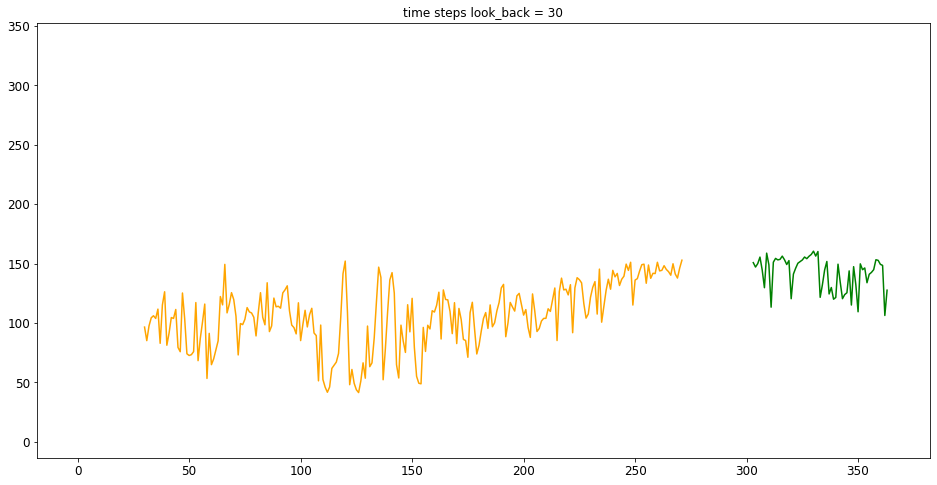

In [132]:
# Plot do baseline e previsões
plt.title('time steps look_back = 30')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

## Prevendo Séries Temporais com LSTMs e Memória Entre Batches

## LSTMs Stateful x Stateless

Uma LSTM prevê com base na ativação da célula de memória no timestep anterior. Você então deve copiar essa ativação entre lotes? Ou você define todas as ativações como zeros? Isso é o que distingue uma LSTM com estado (stateful) e sem estado (stateless). Portanto, o estado refere-se a ativações de neurônios, não aos parâmetros (que são mantidos em ambos os casos).

Quando devemos usar LSTMs em modo stateful ou stateless?

Depende se você deseja que as previsões no lote n dependam do estado no lote n-1. Por exemplo, na modelagem de linguagem, os lotes sucessivos são trocas sucessivas de texto, por isso faz sentido manter o estado. Mas se você sabe que os lotes sucessivos não estão relacionados entre si, talvez seja mais sensato redefinir o estado.

"Stateless" é como redefinir a LSTM para um "estado inicial" a cada novo lote, e 'stateful' significa que você continua de onde você está. Em ambos os casos, a LSTM está aprendendo porque as probabilidades de transição são atualizadas.

A LSTM stateless deve ser usada se as instâncias de diferentes lotes forem independentes, por exemplo, ao modelar padrões de nível de sentença e cada instância for uma frase - o estado deve ser redefinido para "início de sentença" para cada nova instância. LSTM stateful é mais útil se houver continuidade entre a iª instância de todos os lotes, por exemplo, ao modelar padrões de nível de documento (sem redefinir os limites das orações) ou séries temporais. Neste caso, a i-ésima instância de cada lote deve ser as frases consequentes do i-ésimo documento.

## Memória Entre Batches

A rede LSTM possui memória que é capaz de se lembrar através de sequências longas. Normalmente, o estado dentro da rede é reiniciado após cada lote de treinamento ao chamar modelo.fit(), bem como cada chamada para model.predict() ou model.evaluate(). Nós podemos controlar quando o estado interno da rede LSTM é apagado no Keras, fazendo a camada LSTM com estado (usando o parâmetro stateful). Isso significa que podemos criar estado em toda a sequência de treinamento e até mesmo manter esse estado, se necessário, para fazer previsões.

Esta técnica exige que os dados de treino não sejam "shuffled" durante o treinamento da rede. Também requer reinicialização explícita do estado da rede após cada exposição aos dados de treinamento (epoch) com chamadas para model.reset_states(). Isso significa que devemos criar nosso próprio ciclo externo de épocas e dentro de cada epoch, fazer as chamadas a model.fit() e model.reset().

O módulo reset_states() limpa apenas os estados ocultos da sua rede. Vale a pena mencionar que, dependendo se a opção stateful = True foi configurada em sua rede - o comportamento desta função pode ser diferente. Se não estiver configurado - todos os estados são reiniciados automaticamente após cada cálculo de lote em sua rede (por exemplo, depois de chamar model.fit(), model.predict() e model.evaluate()). Caso contrário - você deve chamar reset_states() toda vez, quando quiser fazer chamadas de modelo consecutivas independentes.

Stateful = True geralmente é usado quando você deseja tratar lotes consecutivos como entradas consecutivas. Neste caso, o modelo está tratando lotes consecutivos como se estivessem no mesmo batch.

Quando a camada LSTM for criada, o parâmetro stateful = True deve ser definido e ao invés de especificar a dimensão de entrada, devemos informar o número de amostras em um batch, o número de time steps na amostra e o número de features no time step configurando o parâmetro batch_input_shape. Nossa camada LSTM ficará assim:

model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))

O mesmo batch_size deve ser usado mais tarde para fazer as previsões: model.predict(trainX, batch_size=batch_size)

Configurar uma RNN com stateful = True significa que os estados para as amostras de cada lote serão reutilizados como estados iniciais para as amostras no próximo lote.

In [13]:
# Carrega o dataset
#dataframe = pandas.read_csv('passageiros.csv', usecols = [1], engine = 'python', skipfooter = 3)
#dataset = dataframe.values
#dataset = dataset.astype('float32')

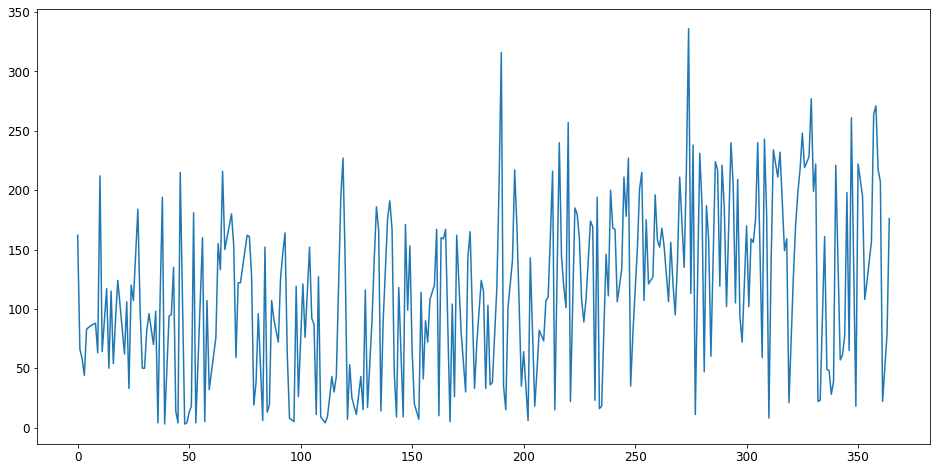

In [153]:
dataset=dataframe.copy()
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

242/242 - 4s - loss: 0.0348
242/242 - 1s - loss: 0.0342
242/242 - 1s - loss: 0.0340
242/242 - 1s - loss: 0.0338
242/242 - 1s - loss: 0.0338
242/242 - 1s - loss: 0.0337
242/242 - 1s - loss: 0.0337
242/242 - 1s - loss: 0.0337
242/242 - 1s - loss: 0.0337
242/242 - 1s - loss: 0.0337
242/242 - 1s - loss: 0.0337
242/242 - 1s - loss: 0.0336
242/242 - 1s - loss: 0.0336
242/242 - 1s - loss: 0.0336
242/242 - 1s - loss: 0.0336
242/242 - 1s - loss: 0.0335
242/242 - 1s - loss: 0.0335
242/242 - 1s - loss: 0.0335
242/242 - 1s - loss: 0.0335
242/242 - 1s - loss: 0.0334
242/242 - 1s - loss: 0.0334
242/242 - 1s - loss: 0.0334
242/242 - 1s - loss: 0.0334
242/242 - 1s - loss: 0.0333
242/242 - 1s - loss: 0.0333
242/242 - 1s - loss: 0.0333
242/242 - 1s - loss: 0.0332
242/242 - 1s - loss: 0.0332
242/242 - 1s - loss: 0.0332
242/242 - 1s - loss: 0.0331
242/242 - 1s - loss: 0.0331
242/242 - 1s - loss: 0.0331
242/242 - 1s - loss: 0.0331
242/242 - 1s - loss: 0.0330
242/242 - 1s - loss: 0.0330
242/242 - 1s - loss:

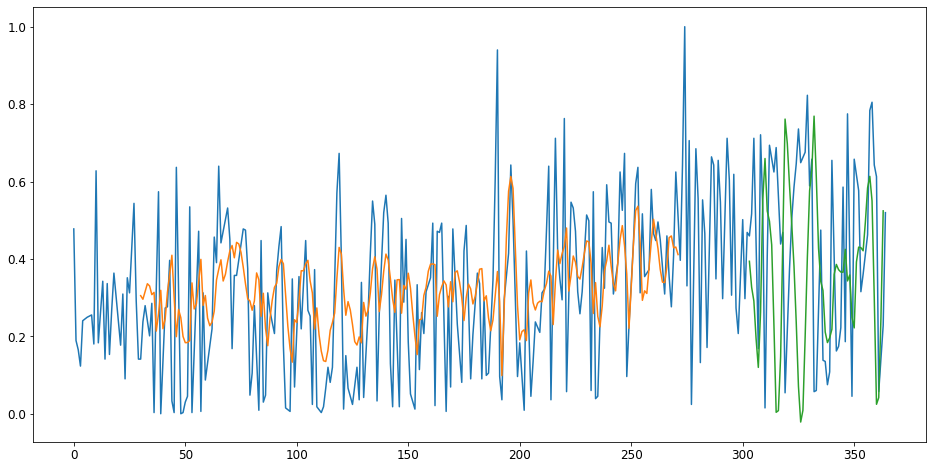

In [158]:
# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Cria o modelo LSTM
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
for i in range(200):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 2, shuffle = False)
    model.reset_states()

# Previsões
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size = batch_size)

# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em teste para o plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot do baseline e previsões
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [135]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 58.73 RMSE
Score em Teste: 79.20 RMSE


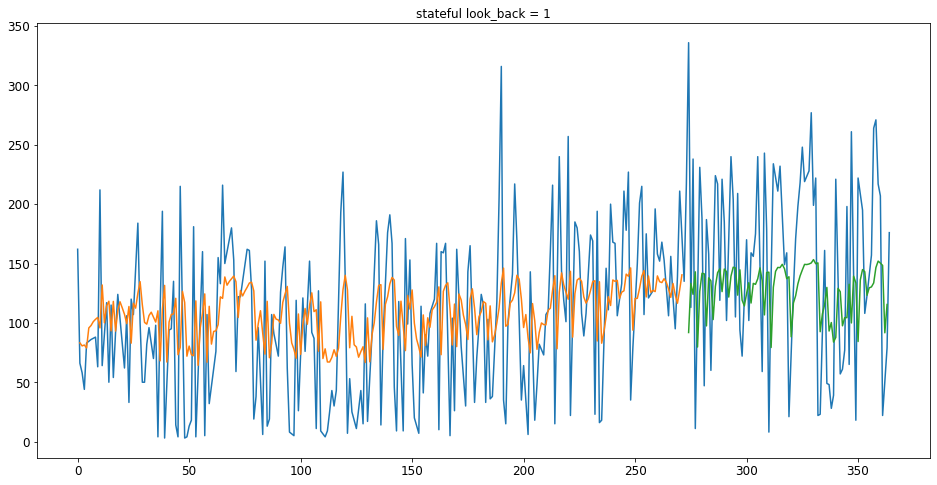

In [136]:
# Plot do baseline e previsões
plt.title('stateful look_back = 1')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

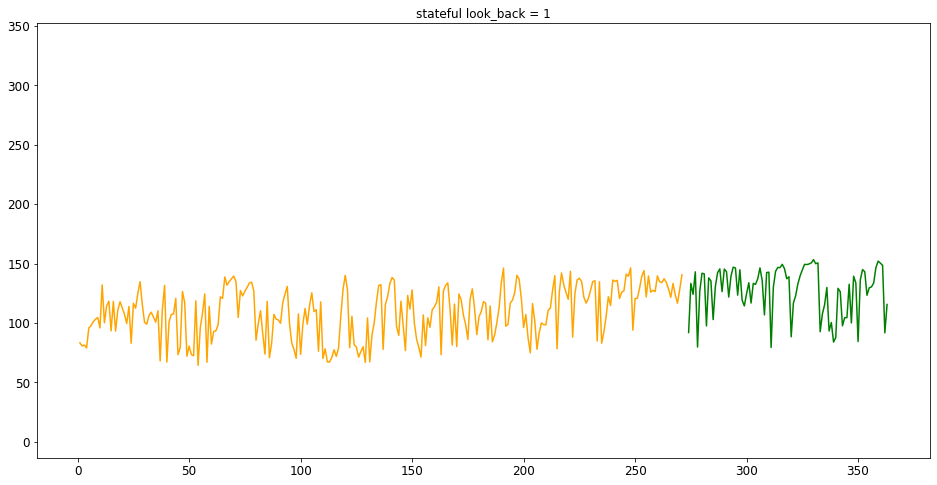

In [137]:
# Plot do baseline e previsões
plt.title('stateful look_back = 1')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [140]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 58.06 RMSE
Score em Teste: 75.73 RMSE


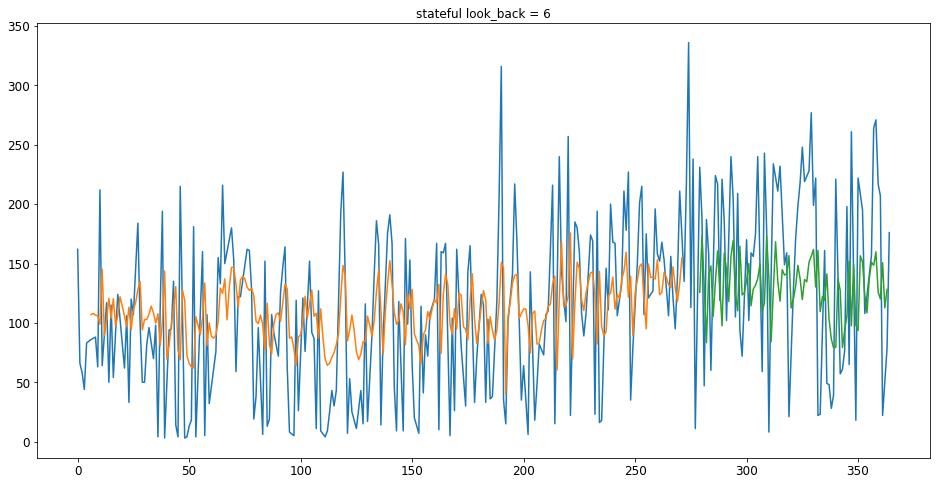

In [141]:
# Plot do baseline e previsões
plt.title('stateful look_back = 6')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

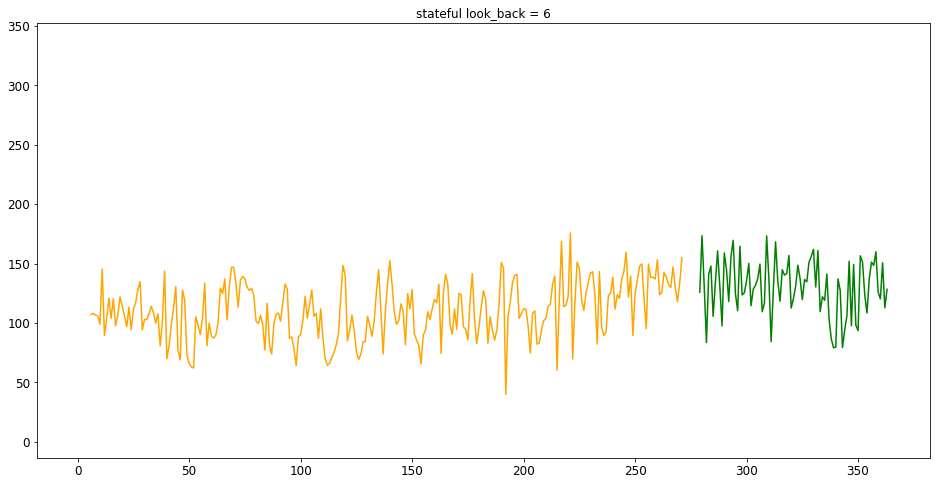

In [142]:
# Plot do baseline e previsões
plt.title('stateful look_back = 6')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [145]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 57.96 RMSE
Score em Teste: 74.93 RMSE


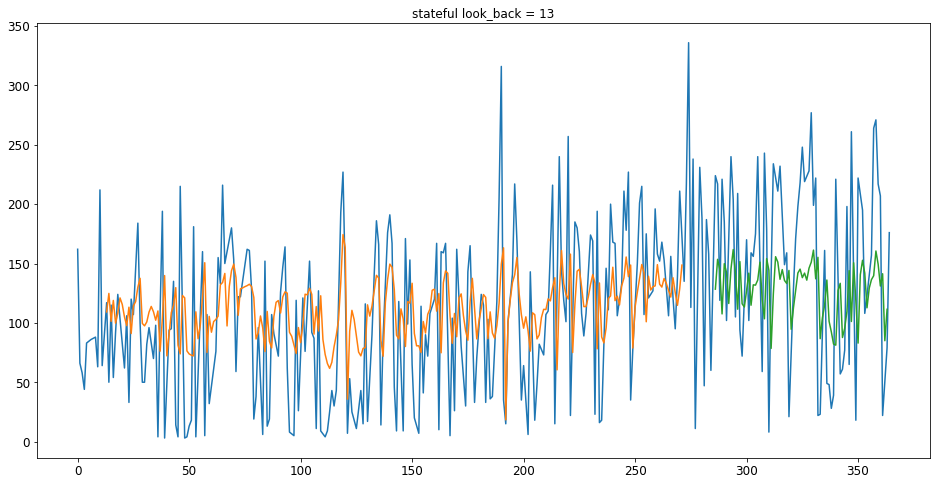

In [146]:
# Plot do baseline e previsões
plt.title('stateful look_back = 13')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

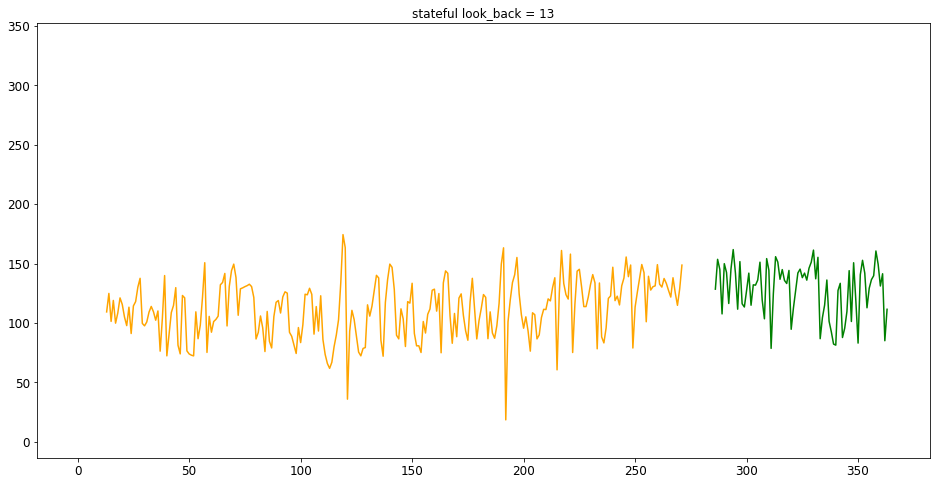

In [147]:
# Plot do baseline e previsões
plt.title('stateful look_back = 13')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [150]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 56.70 RMSE
Score em Teste: 72.08 RMSE


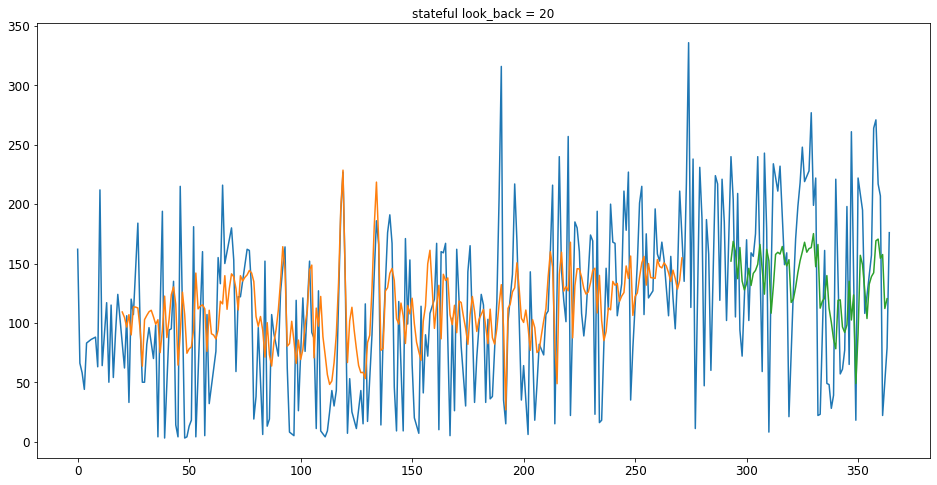

In [151]:
# Plot do baseline e previsões
plt.title('stateful look_back = 20')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

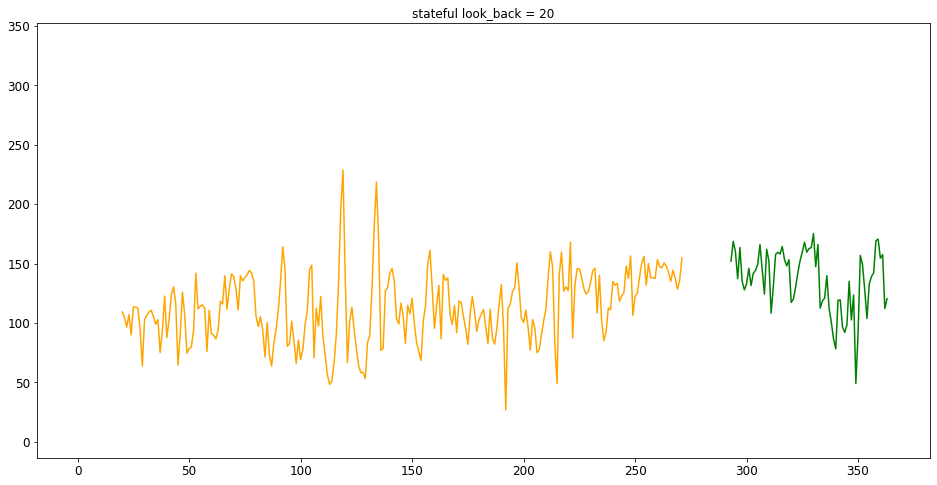

In [152]:
# Plot do baseline e previsões
plt.title('stateful look_back = 20')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

In [ ]:
# Plot do baseline e previsões
plt.title('stateful look_back = 30')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# Plot do baseline e previsões
plt.title('stateful look_back = 30')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [159]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 0.17 RMSE
Score em Teste: 0.34 RMSE


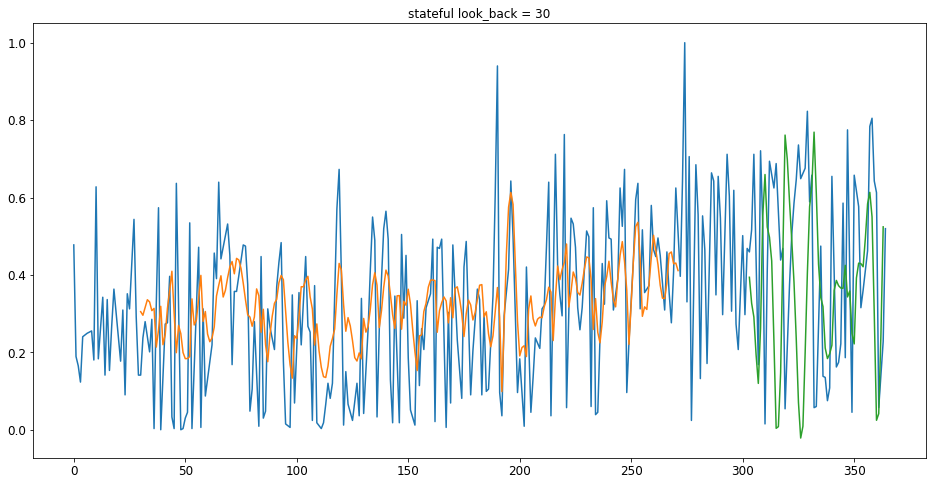

In [160]:
# Plot do baseline e previsões
plt.title('stateful look_back = 30')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

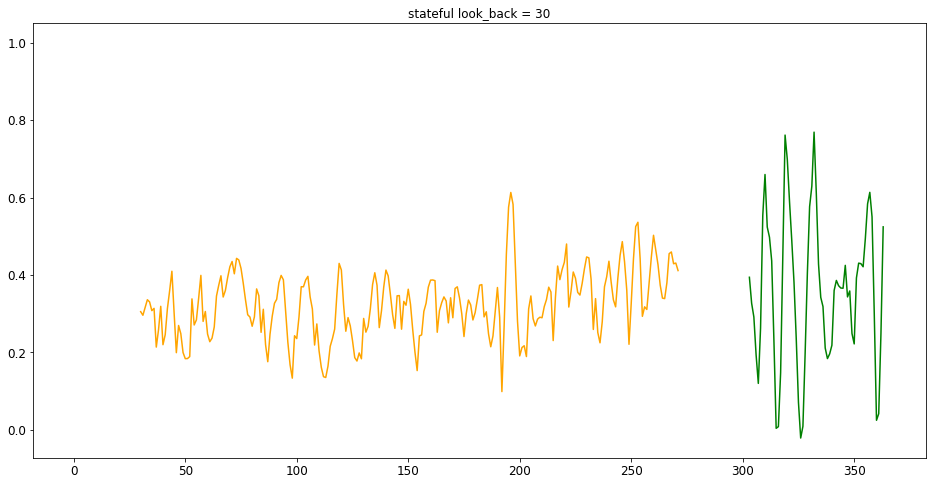

In [161]:
# Plot do baseline e previsões
plt.title('stateful look_back = 30')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

## Prevendo Séries Temporais com Stacked LSTMs 

Finalmente, vejamos um dos maiores benefícios das LSTMs, o fato de que elas podem ser treinadas com sucesso quando empilhadas em arquiteturas de redes profundas. As redes LSTM podem ser empilhadas em Keras da mesma maneira que outros tipos de camada podem ser empilhadas. Uma adição é que a camada LSTM anterior a cada camada LSTM subsequente, deve retornar a sequência. Isso pode ser feito configurando o parâmetro return_sequences = True na camada 1. 

In [15]:
# Carrega o dataset
#dataframe = pandas.read_csv('passageiros.csv', usecols = [1], engine = 'python', skipfooter = 3)
#dataset = dataframe.values
#dataset = dataset.astype('float32')

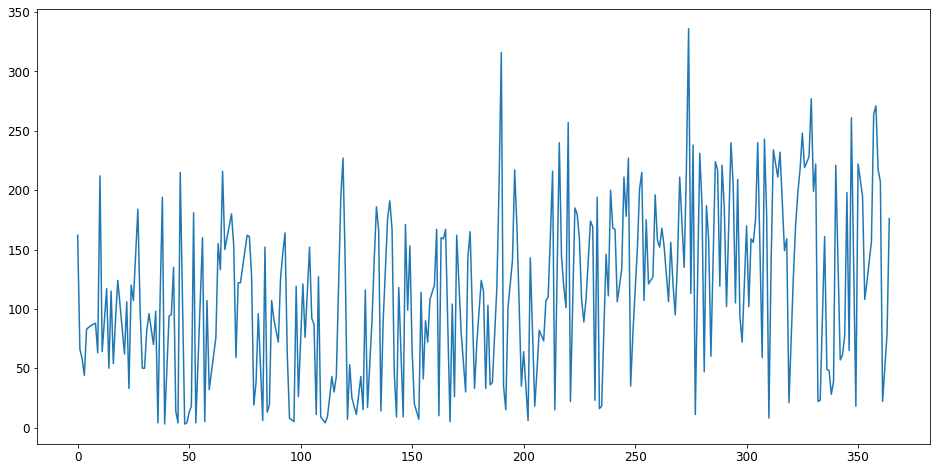

In [28]:
dataset=dataframe.copy()
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

242/242 - 7s - loss: 0.0376
242/242 - 2s - loss: 0.0365
242/242 - 2s - loss: 0.0365
242/242 - 2s - loss: 0.0365
242/242 - 2s - loss: 0.0365
242/242 - 2s - loss: 0.0365
242/242 - 2s - loss: 0.0365
242/242 - 2s - loss: 0.0364
242/242 - 2s - loss: 0.0364
242/242 - 2s - loss: 0.0364
242/242 - 2s - loss: 0.0364
242/242 - 2s - loss: 0.0364
242/242 - 2s - loss: 0.0363
242/242 - 2s - loss: 0.0363
242/242 - 2s - loss: 0.0362
242/242 - 2s - loss: 0.0362
242/242 - 2s - loss: 0.0362
242/242 - 2s - loss: 0.0361
242/242 - 2s - loss: 0.0360
242/242 - 2s - loss: 0.0360
242/242 - 2s - loss: 0.0359
242/242 - 2s - loss: 0.0358
242/242 - 2s - loss: 0.0357
242/242 - 2s - loss: 0.0356
242/242 - 2s - loss: 0.0355
242/242 - 2s - loss: 0.0354
242/242 - 2s - loss: 0.0353
242/242 - 2s - loss: 0.0352
242/242 - 2s - loss: 0.0350
242/242 - 2s - loss: 0.0349
242/242 - 2s - loss: 0.0348
242/242 - 2s - loss: 0.0347
242/242 - 2s - loss: 0.0345
242/242 - 2s - loss: 0.0344
242/242 - 2s - loss: 0.0343
242/242 - 2s - loss:

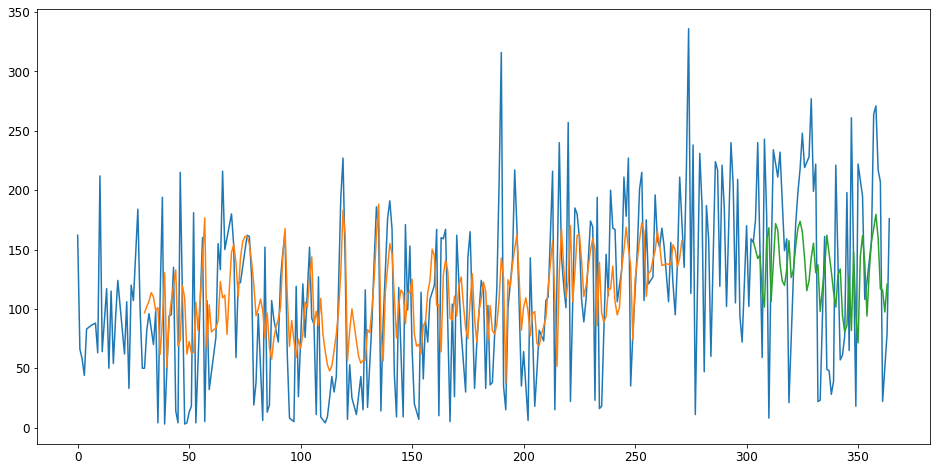

In [29]:
# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Cria o modelo LSTM
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True, return_sequences = True))
model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
for i in range(200):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 2, shuffle = False)
    model.reset_states()

# Previsões
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size = batch_size)

# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em teste para o plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot do baseline e previsões
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [10]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 58.91 RMSE
Score em Teste: 82.51 RMSE


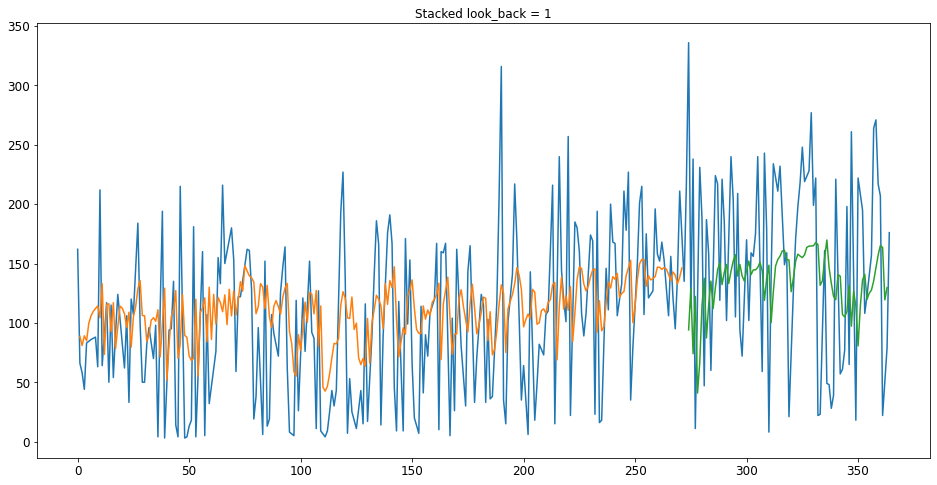

In [11]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 1')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

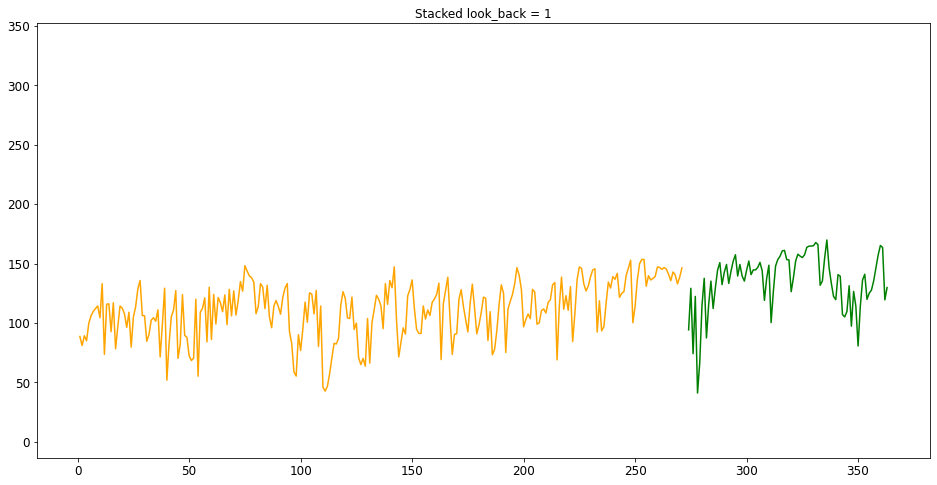

In [12]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 1')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [15]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 55.79 RMSE
Score em Teste: 79.79 RMSE


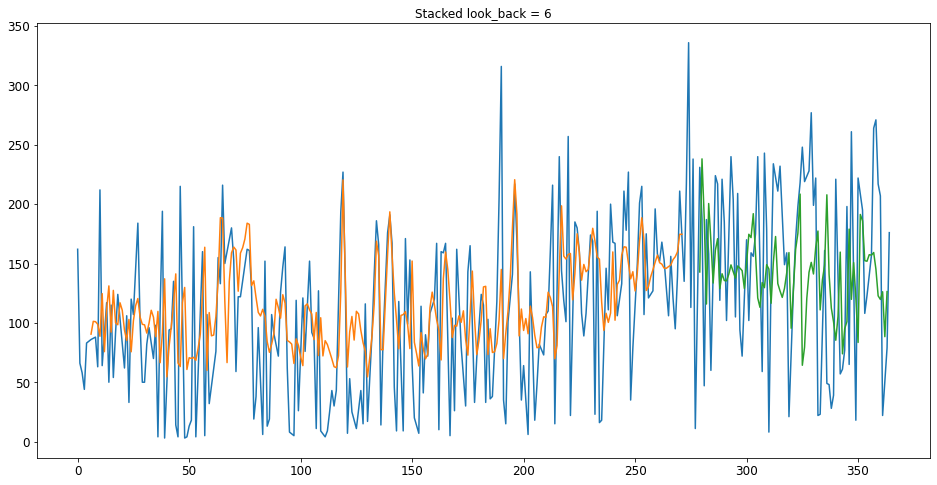

In [16]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 6')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

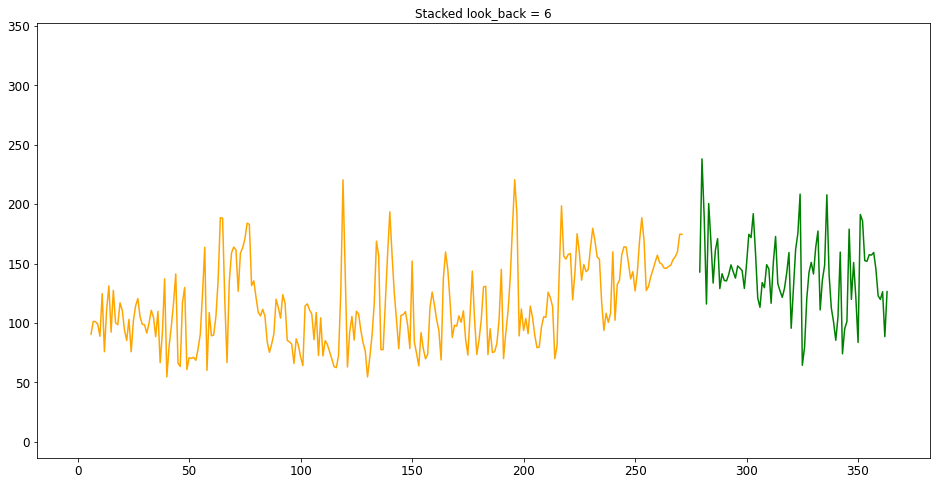

In [17]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 6')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [20]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 56.29 RMSE
Score em Teste: 82.54 RMSE


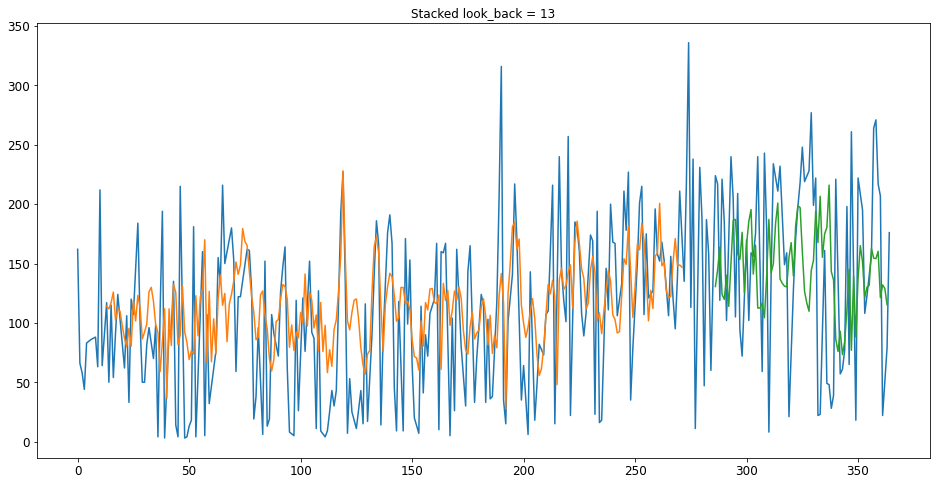

In [21]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 13')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

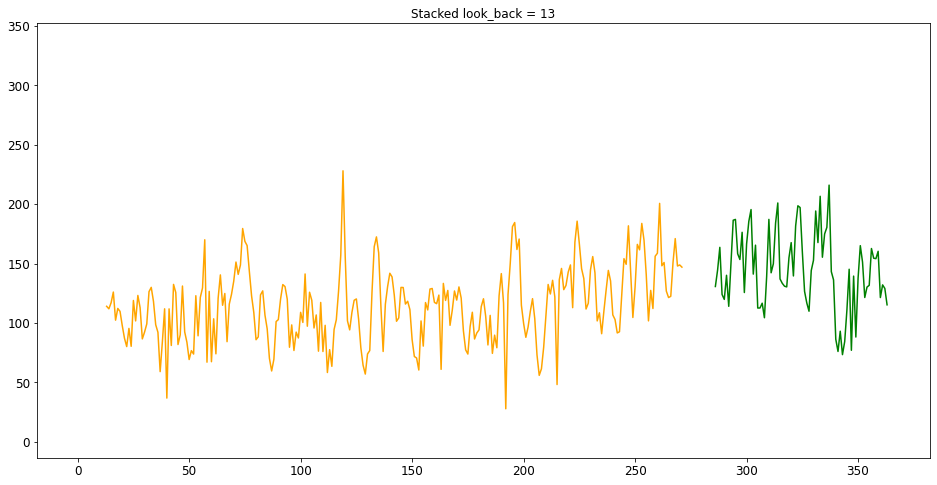

In [22]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 13')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [25]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 55.81 RMSE
Score em Teste: 83.85 RMSE


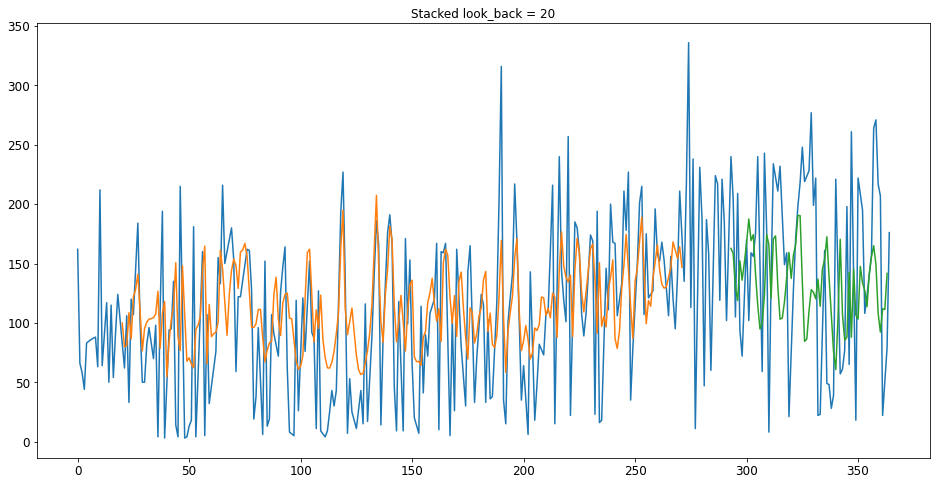

In [26]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 20')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

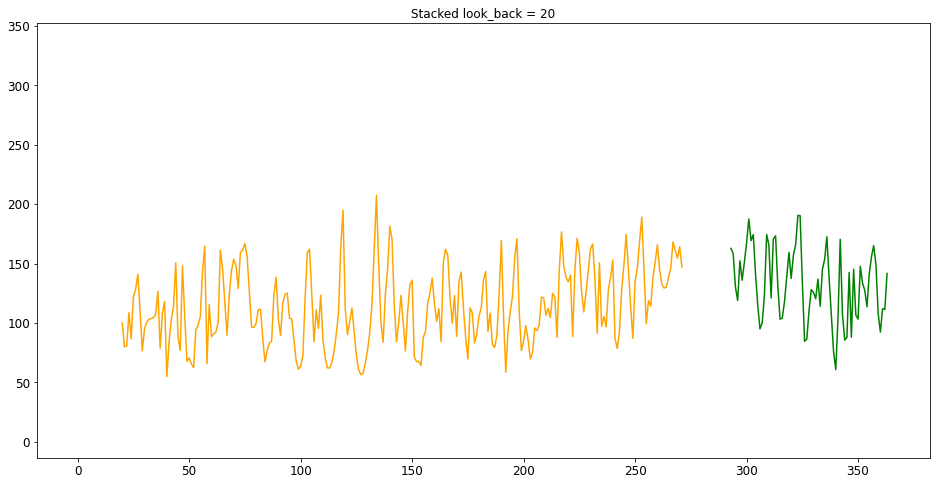

In [27]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 20')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

In [30]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 56.03 RMSE
Score em Teste: 79.33 RMSE


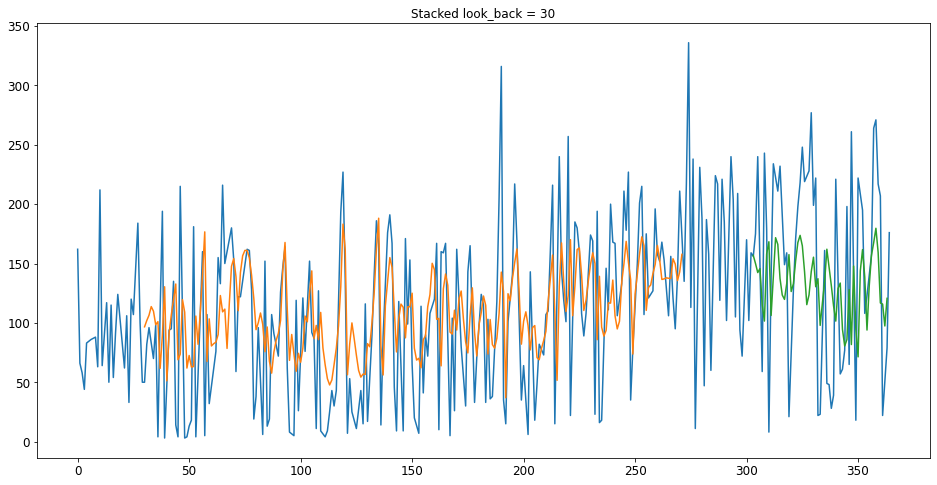

In [31]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 30')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

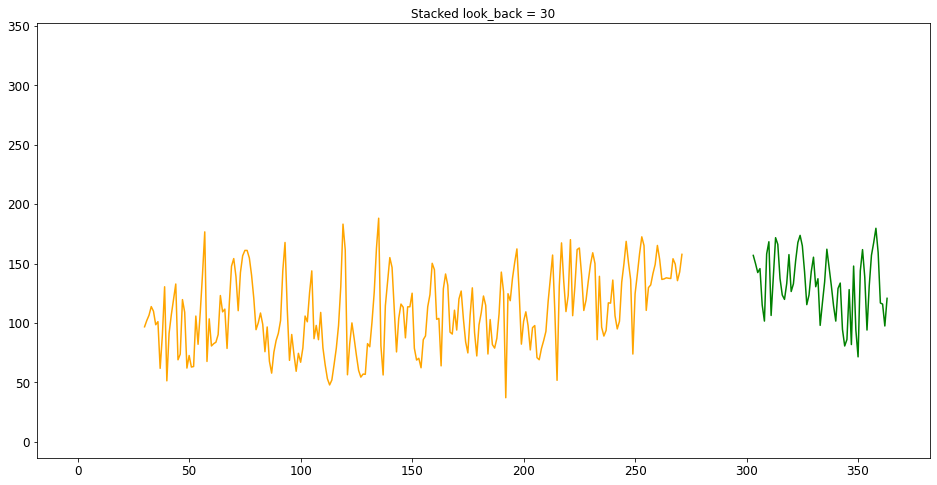

In [32]:
# Plot do baseline e previsões
plt.title('Stacked look_back = 30')
plt.plot(scaler.inverse_transform(dataset), color = 'white')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()

## ARIMA

In [32]:
import pandas as pd
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# importa os pacotes de autocorrelação
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA
import math
from math import sqrt 
from pandas import concat

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
#plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [33]:
# Cria a função que faz a diferenciação
def difference(dataset, interval=1):
  diff = list() 
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# cria função que reverte o valor diferenciado para o original
def inverse_difference(history, previsao, interval=1):
  return previsao + history[-interval]

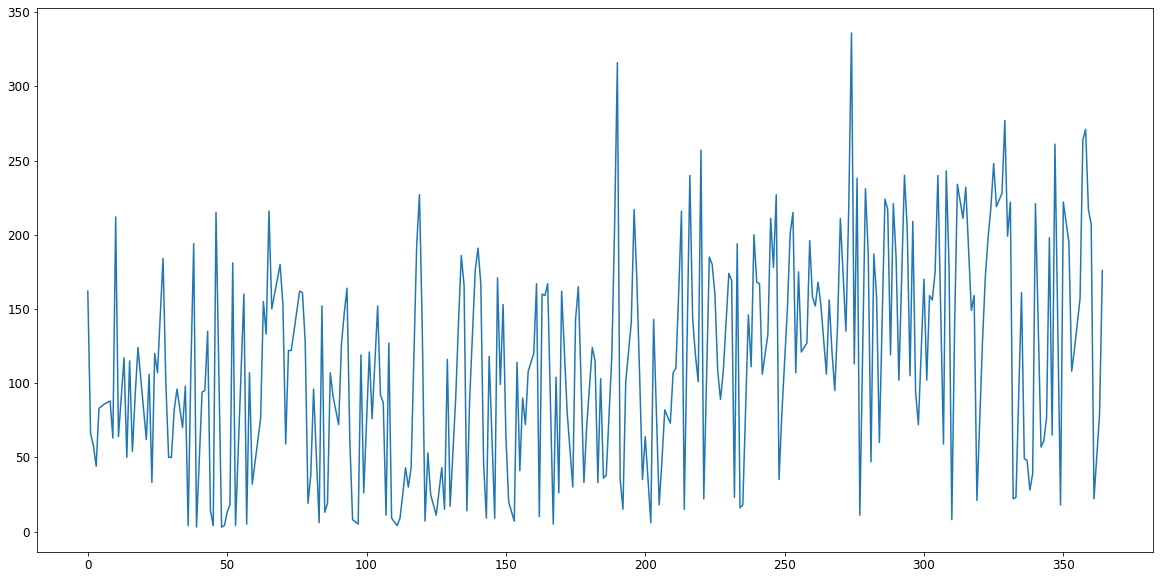

In [34]:
dataset = dataframe.copy()
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [35]:
# a variável X recebe os dados da série
X = dataframe.copy()
X = dataframe.values
X = dataset.astype('float32')

In [36]:
# Separa os dados com 75% dos dados para treino e 50% dos dados para teste
size = int(len(X) * 0.75)

In [37]:
# Separa dados de treino e teste
train = X[0:size]
test =  X[size:]

In [41]:
resultado = pd.DataFrame(test, columns=['dados_teste'])
resultado

dados_teste
0         217.0
1         336.0
2         113.0
3         238.0
4          11.0
..          ...
87        207.0
88         22.0
89         50.5
90         79.0
91        176.0

[92 rows x 1 columns]

In [54]:
# cria a variável history
history = [x for x in train]

# cria lista de previsões
predictions = list()

# inicia Walk-Forward
for t in range(len(test)):
    
    # difference data
    look_back = 30
    diff = difference(history, look_back)

    # cria um modelo ARIMA com os dados de history
    model = ARIMA(diff, order=(1,1,1))

    # treina o modelo ARIMA
    model_fit = model.fit(trend='nc', disp=0)

    # a variável valor_predito recebe o valor previsto pelo modelo
    valor_predito = model_fit.forecast()[0]

    # valor_predito recebe o valor revertido (escala original)
    valor_predito = inverse_difference(history, valor_predito, look_back)

    # adiciona o valor predito na lista de predicões
    predictions.append(valor_predito)

    # a variável valor_real recebe o valor real do teste
    valor_real = test[t]

    # adiciona o valor real a variável history
    history.append(valor_real)

    # imprime valor predito e valor real
    print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=136.189, Valor esperado=217
Valor predito=167.288, Valor esperado=336
Valor predito=274.903, Valor esperado=113
Valor predito=167.994, Valor esperado=238
Valor predito=253.652, Valor esperado= 11
Valor predito=-2.627, Valor esperado=121
Valor predito=107.161, Valor esperado=231
Valor predito=158.562, Valor esperado=188
Valor predito=179.099, Valor esperado= 47
Valor predito=192.015, Valor esperado=187
Valor predito=223.600, Valor esperado=158
Valor predito=105.652, Valor esperado= 60
Valor predito=174.700, Valor esperado=142
Valor predito=122.927, Valor esperado=224
Valor predito=155.145, Valor esperado=217
Valor predito=157.365, Valor esperado=119
Valor predito=205.085, Valor esperado=221
Valor predito=174.043, Valor esperado=185
Valor predito=168.626, Valor esperado=102
Valor predito=167.881, Valor esperado=171
Valor predito=163.664, Valor esperado=240
Valor predito=158.341, Valor esperado=204
Valor predito=133.168, Valor esperado=105
Valor predito=167.355, Valor espera

In [43]:
# Avaliando os resultados look_back = 2
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 106.363


In [44]:
resultado['previsao_2'] = pd.DataFrame((predictions), columns=['previsao_2'])
resultado

dados_teste  previsao_2
0         217.0  163.700060
1         336.0  140.729898
2         113.0  243.692938
3         238.0  324.937295
4          11.0  101.684415
..          ...         ...
87        207.0  267.009285
88         22.0  211.051267
89         50.5  186.602003
90         79.0    3.709108
91        176.0   56.426637

[92 rows x 2 columns]

In [46]:
# Avaliando os resultados look_back = 6
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 101.175


In [47]:
resultado['previsao_6'] = pd.DataFrame((predictions), columns=['previsao_6'])
resultado

dados_teste  previsao_2  previsao_6
0         217.0  163.700060  117.044533
1         336.0  140.729898  119.064134
2         113.0  243.692938  201.067200
3         238.0  324.937295  206.903188
4          11.0  101.684415  181.320038
..          ...         ...         ...
87        207.0  267.009285  151.606190
88         22.0  211.051267  162.744117
89         50.5  186.602003  129.172001
90         79.0    3.709108  238.277125
91        176.0   56.426637  224.041280

[92 rows x 3 columns]

In [49]:
# Avaliando os resultados look_back = 13
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 95.913


In [50]:
resultado['previsao_13'] = pd.DataFrame((predictions), columns=['previsao_13'])
resultado

dados_teste  previsao_2  previsao_6  previsao_13
0         217.0  163.700060  117.044533   146.624697
1         336.0  140.729898  119.064134   167.112951
2         113.0  243.692938  201.067200   212.013147
3         238.0  324.937295  206.903188   143.992525
4          11.0  101.684415  181.320038   150.326424
..          ...         ...         ...          ...
87        207.0  267.009285  151.606190   301.720115
88         22.0  211.051267  162.744117   128.600205
89         50.5  186.602003  129.172001    -9.227062
90         79.0    3.709108  238.277125   232.034801
91        176.0   56.426637  224.041280   175.353349

[92 rows x 4 columns]

In [52]:
# Avaliando os resultados look_back = 20
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 97.602


In [53]:
resultado['previsao_20'] = pd.DataFrame((predictions), columns=['previsao_2'])
resultado

dados_teste  previsao_2  previsao_6  previsao_13  previsao_20
0         217.0  163.700060  117.044533   146.624697   199.000340
1         336.0  140.729898  119.064134   167.112951   110.539597
2         113.0  243.692938  201.067200   212.013147   244.613330
3         238.0  324.937295  206.903188   143.992525   107.949781
4          11.0  101.684415  181.320038   150.326424   159.113648
..          ...         ...         ...          ...          ...
87        207.0  267.009285  151.606190   301.720115   277.101995
88         22.0  211.051267  162.744117   128.600205   137.603512
89         50.5  186.602003  129.172001    -9.227062    24.724483
90         79.0    3.709108  238.277125   232.034801    61.299669
91        176.0   56.426637  224.041280   175.353349    84.638783

[92 rows x 5 columns]

In [55]:
# Avaliando os resultados look_back = 30
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 99.545


In [56]:
resultado['previsao_30'] = pd.DataFrame((predictions), columns=['previsao_30'])
resultado

dados_teste  previsao_2  previsao_6  previsao_13  previsao_20  previsao_30
0         217.0  163.700060  117.044533   146.624697   199.000340   136.188946
1         336.0  140.729898  119.064134   167.112951   110.539597   167.288106
2         113.0  243.692938  201.067200   212.013147   244.613330   274.903308
3         238.0  324.937295  206.903188   143.992525   107.949781   167.993965
4          11.0  101.684415  181.320038   150.326424   159.113648   253.652306
..          ...         ...         ...          ...          ...          ...
87        207.0  267.009285  151.606190   301.720115   277.101995   188.371211
88         22.0  211.051267  162.744117   128.600205   137.603512   226.476077
89         50.5  186.602003  129.172001    -9.227062    24.724483   -20.184607
90         79.0    3.709108  238.277125   232.034801    61.299669    31.378752
91        176.0   56.426637  224.041280   175.353349    84.638783   106.628430

[92 rows x 6 columns]

In [66]:
resultado.to_csv('resultado.csv')

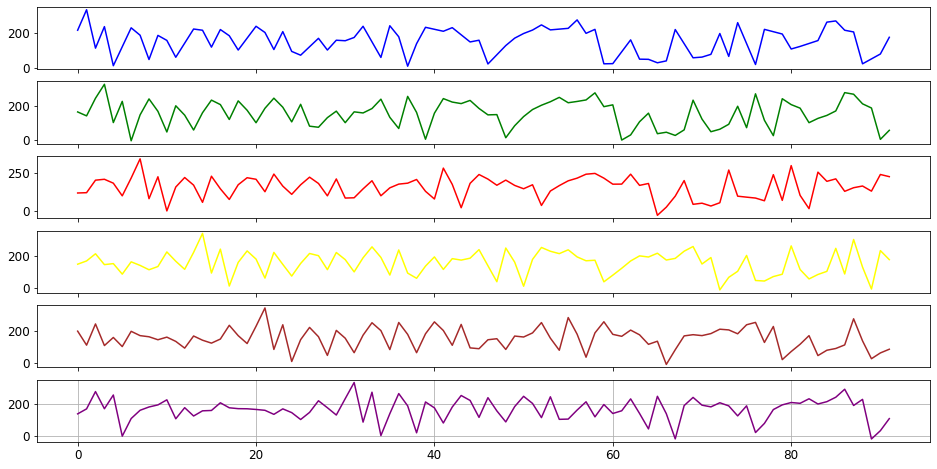

In [87]:
# Área de Plotagem
fig, axes = plt.subplots(6, sharex = True)
axes[0].plot(resultado['dados_teste'], color='blue');
axes[1].plot(resultado['previsao_2'], color='green');
axes[2].plot(resultado['previsao_6'], color='red');
axes[3].plot(resultado['previsao_13'], color='yellow');
axes[4].plot(resultado['previsao_20'], color='brown');
axes[5].plot(resultado['previsao_30'], color='purple');
#plt.grid()
plt.show();

In [61]:
# erros residuais 
residuals = [test[i] - predictions[i] for i in range(len(test))]

In [63]:
# converte a lista em um dataframe
residuals = pandas.DataFrame(residuals)

In [64]:
# imprime as 5 primeiras linhas
residuals.head()

0
0   69.933568
1  147.648704
2  -91.021536
3  117.424907
4 -127.787696

In [65]:
# estatística descritiva
residuals.describe()

0
count   92.000000
mean    -1.265399
std     99.813694
min   -174.734302
25%    -85.153088
50%     -3.721423
75%     62.046457
max    239.470934

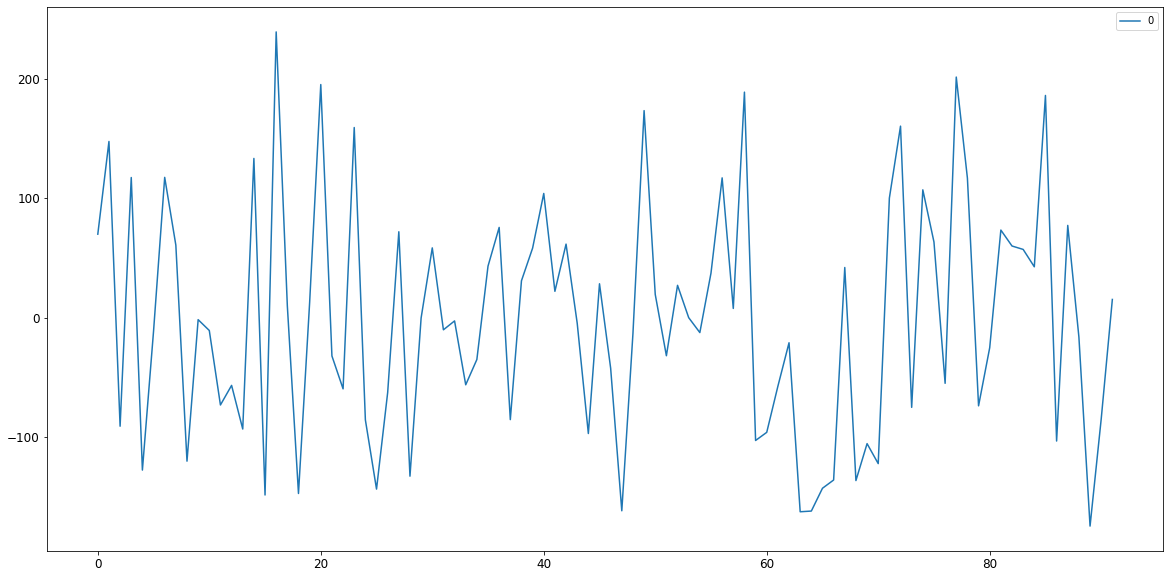

In [72]:
# plot residuals
residuals.plot()
plt.show()

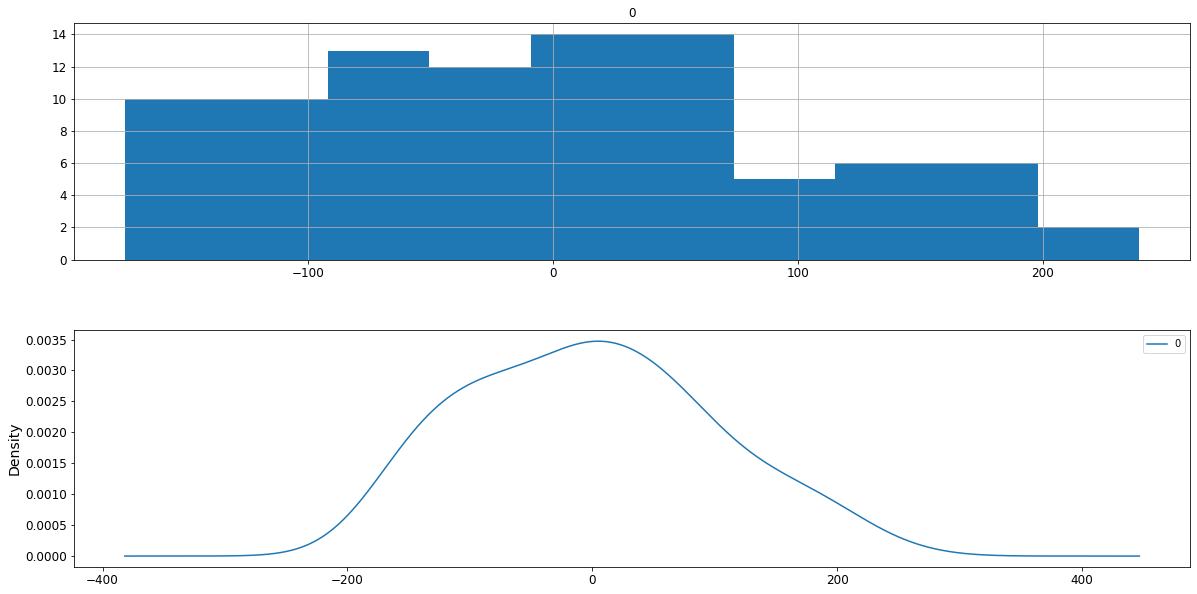

In [78]:
# plots histograma
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())

plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

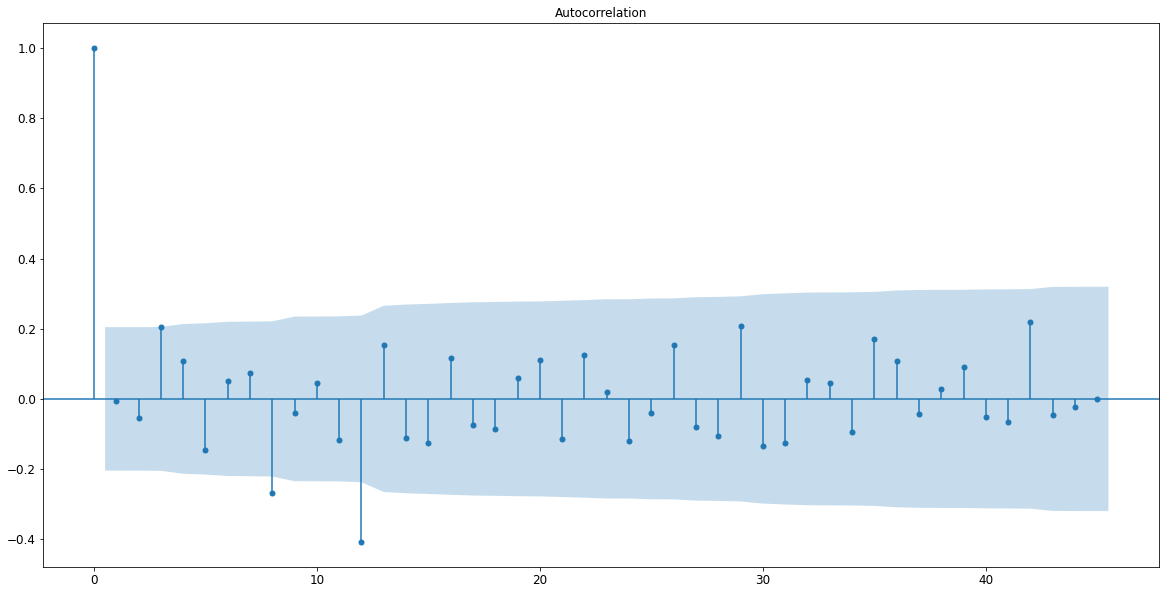

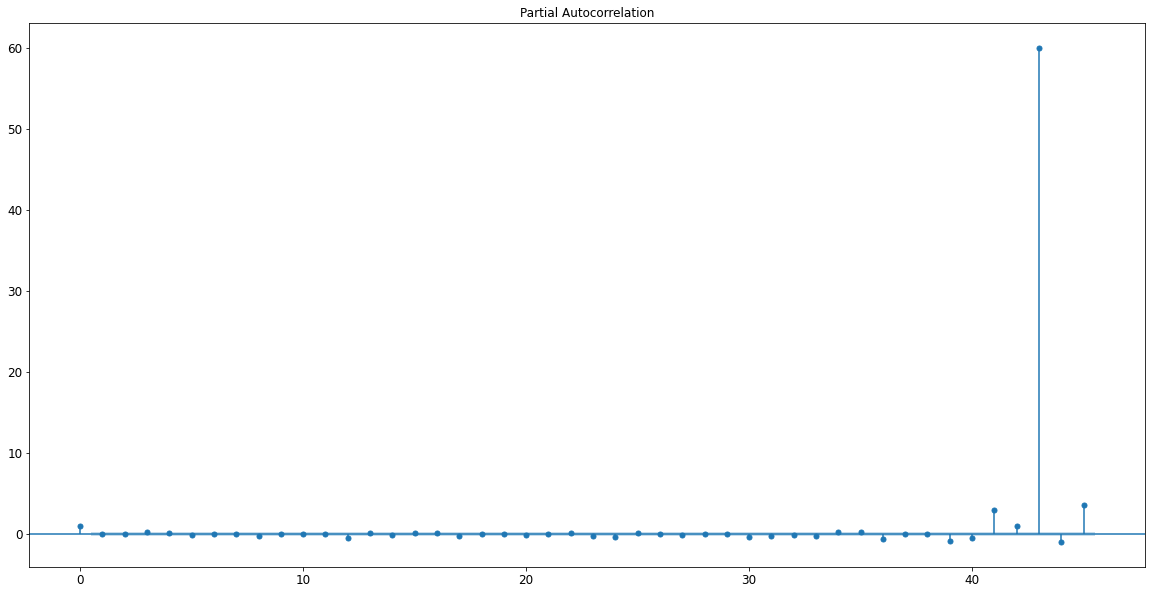

In [89]:
plot_acf(residuals, lags=45)
plot_pacf(residuals, lags=45)
plt.show()

# Fim